# Final Demo

## Load Library

In [179]:
import os, sys
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [1]:
import fasttext
import csv
import MeCab
import random
import numpy as np
import pickle
from tqdm import tqdm

import torch
import gluonnlp as nlp
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from CustomModel import BERTClassifier

from text import Text, Word
from infer import predict
from attacks import GreedyAttack, GeneticAttack, PSOAttack, PerturbBaseline

In [151]:
import importlib
import attacks
attacks = importlib.reload(attacks)
GeneticAttack = attacks.GeneticAttack
GreedyAttack = attacks.GreedyAttack
PSOAttack = attacks.PSOAttack
PerturbBaseline = attacks.PerturbBaseline

In [161]:
import importlib
import text
text = importlib.reload(text)
Text = text.Text
Word = text.Word

In [89]:
# load documents
data_path = '/home/ubuntu/workspace/kaist.sbse/proj/data/ratings_test.txt'
ids, documents, targets = [], [], []
with open(data_path, 'r') as f:
    lines = list(csv.reader(f, delimiter='\t'))
    header = lines.pop(0)
    for line in lines:
        ids.append(line[0])
        documents.append(line[1])
        targets.append(int(line[2]))

In [183]:
with open('./data/rating_test_spell.pkl', 'wb') as f:
    pickle.dump({'documents' : spell_documents, 'targets' : targets, 'scores': scores}, f)

In [184]:
with open('./data/rating_test_spell.pkl', 'rb') as f:
    d = pickle.load(f)
    spell_documents = d['documents']
    targets = d['targets']
    scores = d['scores']

In [3]:
# load embedding model
embedding_model = fasttext.load_model('/home/ubuntu/workspace/kaist.sbse/proj/data/cc.ko.300.bin')

In [4]:
# load Mecab
tagger = MeCab.Tagger('-d /home/ubuntu/workspace/kaist.sbse/mecab-ko-dic-2.1.1-20180720')

## Document Data EDA

In [ ]:
import matplotlib.pyplot as plt

In [5]:
# filter documents
doc_leng = [len(d.split()) for d in spell_documents]
print(np.mean(doc_leng))

9.51208


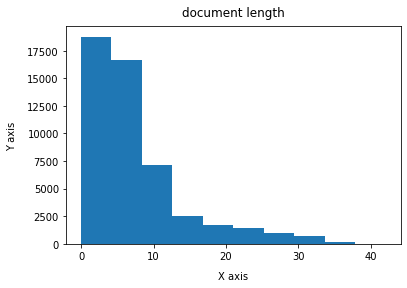

In [ ]:
hist = plt.hist(doc_leng, bins=10)

plt.title('document length', pad=10)
plt.xlabel('X axis', labelpad=10)
plt.ylabel('Y axis', labelpad=10)

plt.show()

In [6]:
test = [(d, t) for d, t in zip(spell_documents, targets) if len(d.split()) >= 5 and len(d.split()) < 20]
print(len(test))

31310


## Load Model

In [24]:
# load sentiment model
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# ### argument
# max_len = 64
# batch_size = 64
# ###

bertmodel, vocab = get_pytorch_kobert_model()
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

sa_model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
checkpoint = torch.load('./model/pytorch_model.bin')['model_state_dict']
sa_model.load_state_dict(checkpoint)

using cached model
using cached model
using cached model


<All keys matched successfully>

In [ ]:
preds, scores = predict(spell_documents, tok, sa_model)

In [7]:
target_scores = []
for s in scores:
    target_scores.append(s.cpu().numpy())
# for t, s in zip(targets, scores):
#     target_scores.append(s[t].cpu().numpy())

NameError: name 'scores' is not defined

In [ ]:
with open('./result/test_pred.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['text', 'label', '0_pred', '1_pred'])
    for t, l, score in zip(spell_documents, targets, target_scores):
        writer.writerow([t, l, round(score[0], 3), round(score[1], 3)])

In [5]:
scores =[]
with open('./result/test_pred.csv', 'r', newline='') as f:
    lines = list(csv.reader(f))
    header = lines.pop(0)
    for line in lines:
        scores.append((line[2], line[3]))

## Attacks

In [8]:
# create text obj from documents
random.seed(0)
sample = random.sample(test, 1)[0]
x_orig = sample[0]
adv_target = 0 if sample[1] == 1 else 1
print(sample, adv_target)

('담백한 느낌이 좋네요.. 8점대는 되는 영화 같아서 끌어올리기', 1) 0


In [9]:
x_orig

'담백한 느낌이 좋네요.. 8점대는 되는 영화 같아서 끌어올리기'

In [10]:
# arguments
pop_size = 20
max_iters = 10
###

In [ ]:
# run attacks (ga) + check sucess rate
ga_attack = GeneticAttack(pop_size=pop_size, max_iters=max_iters, embedding_model=embedding_model, sa_model=sa_model, tokenizer=tok, tagger=tagger)
# adv = ga_attack.attack(x_orig, adv_target)

In [ ]:
adv[0].text

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# run attacks (pso) + check sucess rate
pso_attack = PSOAttack(pop_size=pop_size, max_iters=max_iters, embedding_model=embedding_model, sa_model=sa_model, tokenizer=tok, tagger=tagger)
# adv = pso_attack.attack(x_orig, adv_target)

In [ ]:
# run attacks (greedy) + check sucess rate
gr_attack = GreedyAttack(pop_size=pop_size, max_iters=max_iters, embedding_model=embedding_model, sa_model=sa_model, tokenizer=tok, tagger=tagger)
# adv = gr_attack.attack(x_orig, adv_target)

In [ ]:
# run attack (perterb baseline)
base_attack = PerturbBaseline(pop_size=pop_size, max_iters=max_iters, embedding_model=embedding_model, sa_model=sa_model, tokenizer=tok, tagger=tagger)
adv = base_attack.attack(x_orig, adv_target)

# Pilot Demo

In [ ]:
import fasttext
import csv
import random
import traceback
import copy

In [ ]:
import MeCab
m = MeCab.Tagger('-d /home/ubuntu/workspace/kaist.sbse/mecab-ko-dic-2.1.1-20180720')

In [ ]:
data_path = '/home/ubuntu/workspace/kaist.sbse/proj/data/ratings_test.txt'
ids, documents, targets = [], [], []
with open(data_path, 'r') as f:
    lines = list(csv.reader(f, delimiter='\t'))
    header = lines.pop(0)
    for line in lines:
        ids.append(line[0])
        documents.append(line[1])
        targets.append(int(line[2]))

In [ ]:
random.seed(20)
# filter_documents = [d for d in documents if len(d) > 100]
# test = random.choice(filter_documents)
test = random.sample(documents, 10)
print(test)

['괜찮네...', '에휴 ... 만 나오네요', '영화보면서 딴 짓을 하게 만드는 영화', '겁나 재밌엌ㅋㅋㅋㅋㅋㅋㅋ웃기다', '안중근의사를 주윤발로 만들어버리는 서세원의 한심한 영화', '일본인다운 영화다...딱히 할 말은 없네 쩝..', '수준낮은 내게도 너무 헛웃음이 나온 영화 조승우란 배우도 이 영화만 보면 가치가 전혀 없어보이고... 지고지순한 사랑으로 표현되어야 할것이 오글거리는 어린애 풋사랑만도 못해보이니 참으로 배우나 제작비가 아까워보입니다,.', '이성재 너무열심히하네 허허 찰싹찰싹 찰지네', '이런 류의 영화에 관심 있는 분들은 횡재한거. 전혀 이해가 안가는 점수 우리 나라에서는 제대로 된 sf류라고는 찾아보기도 힘든데 할 말이 없음 . sf 영화 찍기도 힘든데 이렇게 제대로 만들기도 힘듬', '결말은 안봤는데 재밌던뎅 ㅠ']


In [ ]:
embedding_model = fasttext.load_model('/home/ubuntu/workspace/kaist.sbse/proj/data/cc.ko.300.bin')

In [ ]:
embedding_model.get_nearest_neighbors('가치가', k=100)

[(0.7149418592453003, '가치도'),
 (0.7033546566963196, '가치는'),
 (0.6167633533477783, '가치를'),
 (0.5784568190574646, '가치에'),
 (0.5766178369522095, '사료적'),
 (0.5683567523956299, '가치'),
 (0.5560916066169739, '값어치가'),
 (0.5515071153640747, '문화재적'),
 (0.5505257248878479, '뉴스로서의'),
 (0.5487533211708069, '보존할만한'),
 (0.5476403832435608, '자료적인'),
 (0.5461577773094177, '가치와'),
 (0.5438748002052307, '연구해볼'),
 (0.5336384773254395, '가치보다'),
 (0.5210453867912292, '정보로서의'),
 (0.518497884273529, '민속자료로서'),
 (0.5176005363464355, '의미가'),
 (0.5149702429771423, '일고의'),
 (0.5142812132835388, '점수적인'),
 (0.5116618275642395, '재평가될'),
 (0.5116174817085266, '가치의'),
 (0.510407030582428, '존중받을'),
 (0.509033739566803, '사용가치가'),
 (0.5009545683860779, '학술자료로서'),
 (0.4989953637123108, '자료적'),
 (0.49467700719833374, '재산적'),
 (0.4934868812561035, '연구가치가'),
 (0.49255967140197754, '높겠지요'),
 (0.49151405692100525, '가치만'),
 (0.4907607436180115, '기술할만한'),
 (0.4870331585407257, '가치로'),
 (0.48633453249931335, '효용이'),
 (0.485524863

### Replace a word in a sentence

In [ ]:
print(test)
node = m.parseToNode(test[6])
tokens = []
while node:
    if node.surface:
        tokens.append(f"{node.surface}/{node.feature.split(',')[0]}/{len(node.surface)}")
    node = node.next
print(tokens)

re_test = '수준낮은 내게도 너무 헛웃음이 나온 영화 조승우란 배우도 이 영화만 보면 시장성이 전혀 없어보이고... 지고지순한 사랑으로 표현되어야 할것이 오글거리는 어린애 풋사랑만도 못해보이니 참으로 배우나 제작비가 아까워보입니다,.'
node = m.parseToNode(re_test)
tokens = []
while node:
    if node.surface:
        tokens.append(f"{node.surface}/{node.feature.split(',')[0]}/{len(node.surface)}")
    node = node.next
print(tokens)

['괜찮네...', '에휴 ... 만 나오네요', '영화보면서 딴 짓을 하게 만드는 영화', '겁나 재밌엌ㅋㅋㅋㅋㅋㅋㅋ웃기다', '안중근의사를 주윤발로 만들어버리는 서세원의 한심한 영화', '일본인다운 영화다...딱히 할 말은 없네 쩝..', '수준낮은 내게도 너무 헛웃음이 나온 영화 조승우란 배우도 이 영화만 보면 가치가 전혀 없어보이고... 지고지순한 사랑으로 표현되어야 할것이 오글거리는 어린애 풋사랑만도 못해보이니 참으로 배우나 제작비가 아까워보입니다,.', '이성재 너무열심히하네 허허 찰싹찰싹 찰지네', '이런 류의 영화에 관심 있는 분들은 횡재한거. 전혀 이해가 안가는 점수 우리 나라에서는 제대로 된 sf류라고는 찾아보기도 힘든데 할 말이 없음 . sf 영화 찍기도 힘든데 이렇게 제대로 만들기도 힘듬', '결말은 안봤는데 재밌던뎅 ㅠ']
['수준/NNG/2', '낮/VA/1', '은/ETM/1', '내게도/NP+JKB+JX/3', '너무/MAG/2', '헛웃음/NNG/3', '이/JKS/1', '나온/VV+ETM/2', '영화/NNG/2', '조승우/NNP/3', '란/VCP+ETM/1', '배우/NNG/2', '도/JX/1', '이/MM/1', '영화/NNG/2', '만/JX/1', '보/VV/1', '면/EC/1', '가치/NNG/2', '가/JKS/1', '전혀/MAG/2', '없/VA/1', '어/EC/1', '보이/VV/2', '고/EC/1', './SF/1', '../SY/2', '지고지순/NNG/4', '한/XSA+ETM/1', '사랑/NNG/2', '으로/JKB/2', '표현/NNG/2', '되/XSV/1', '어야/EC/2', '할/VX+ETM/1', '것/NNB/1', '이/JKS/1', '오글거리/VV/4', '는/ETM/1', '어린애/NNG/3', '풋사랑/NNG/3', '만/JX/1', '도/JX/1', '못/MAG/1', '해/VV+EC/1', '보이/VV/2', '니/EC/1', '참으로/MAG/3', '배우/NNG/2',

In [ ]:
def using_split2(line, _len=len):
    words = line.split()
    index = line.index
    offsets = []
    append = offsets.append
    running_offset = 0
    for word in words:
        word_offset = index(word, running_offset)
        word_len = _len(word)
        running_offset = word_offset + word_len
        append((word, word_offset, running_offset - 1))
    return offsets

In [ ]:
splits = using_split2(test)

In [ ]:
print(tokens)
print(splits)
cur = 0
pos = 0
ret = []
for sp in splits:
    tmp = []
    length = sp[2]-sp[1]+1
    for to in tokens[pos:]:
        if length > 0:
            l = int(to.split('/')[2])
            length -= l
            tmp.append(to)
            pos += 1
        else:
            break
    ret.append(tmp)
print(ret)
    

['서양인/NNG/3', '들/XSN/1', '이/JKS/1', '하/VV/1', '는/ETM/1', '사랑/NNG/2', '소꿉/NNG/2', '놀이/NNG/2', '에/JKB/1', '본인/NNG/2', '들/XSN/1', '의/JKG/1', '자각/NNG/2', '이/JKS/1', '없/VA/1', '어서/EC/2', '그러/VV/2', '는/ETM/1', '줄/NNB/1', '알/VV/1', '았/EP/1', '는데/EF/2', './SF/1', './SY/1', '어느/MM/2', '정도/NNG/2', '알/VV/1', '기/ETN/1', '는/JX/1', '하/VV/1', '는/ETM/1', '것/NNB/1', '같/VA/1', '다/EF/1', './SF/1', '뻔한/VA+ETM/2', '로맨틱/NNG/3', '코미디/NNG/3', '보다/JKB/2', '는/JX/1', '낫/VA/1', '지만/EC/2', '전체/NNG/2', '적/XSN/1', '으로/JKB/2', './SF/1', './SY/1', '너무/MAG/2', '두서없/VA/3', '고/EC/1', '장면/NNG/2', '위주/NNG/2', './SF/1', '../SY/2', '대화/NNG/2', '도/JX/1', '없/VA/1', '고/EC/1']
[('서양인들이', 0, 4), ('하는', 6, 7), ('사랑', 9, 10), ('소꿉놀이에', 12, 16), ('본인들의', 18, 21), ('자각이', 23, 25), ('없어서', 27, 29), ('그러는줄', 31, 34), ('알았는데..', 36, 41), ('어느정도', 43, 46), ('알기는', 48, 50), ('하는것', 52, 54), ('같다.', 56, 58), ('뻔한', 60, 61), ('로맨틱코미디보다는', 63, 71), ('낫지만', 73, 75), ('전체적으로..', 77, 83), ('너무', 85, 86), ('두서없고', 88, 91), ('장면위주...', 93, 99), (

In [ ]:
class Word:
    def __init__(self, idx, word, start_idx, end_idx) -> None:
        self.idx = idx
        self.word = word
        self.start_idx = start_idx
        self.end_idx = end_idx
        self.tokens = []

class Text:
    def __init__(self, text, tagger) -> None:
        # self.m = MeCab.Tagger()
        self.text = text
        self.offset_text = self.getOffset(self.text)
        self.morphs_text = self.getMorphs(self.text, tagger)
        self.tokens_per_word = self.addPos(self.offset_text, self.morphs_text)
        self.words = [Word(idx, word, start_idx, end_idx) for idx, (word, start_idx, end_idx) in enumerate(self.offset_text)]
        for word, tokens in zip(self.words, self.tokens_per_word):
            word.tokens = tokens

    def __getitem__(self, i):
        return self.words[i]

    def getOffset(self, text):
        words = text.split()
        index = text.index
        offsets = []
        append = offsets.append
        running_offset = 0
        for word in words:
            word_offset = index(word, running_offset)
            word_len = len(word)
            running_offset = word_offset + word_len
            append((word, word_offset, running_offset - 1))
        return offsets
    
    def getMorphs(self, text, tagger):
        # node = self.m.parseToNode(text)
        node = tagger.parseToNode(text)
        tokens = []
        while node:
            if node.surface:
                tokens.append(f"{node.surface}//{node.feature.split(',')[0]}//{len(node.surface)}")
            node = node.next
        return tokens

    def addPos(self, offset_text, morphs_text):
        cur_pos = 0
        tokens_per_word = []
        for offsets in offset_text:
            tmp = []
            length = offsets[2]-offsets[1]+1
            for token in morphs_text[cur_pos:]:
                if length > 0:
                    l = int(token.split('//')[2])
                    length -= l
                    tmp.append((token.split('//')[0], token.split('//')[1]))
                    cur_pos += 1
                else:
                    break
            tokens_per_word.append(tmp)
        return tokens_per_word

    def getReplaceCandidates(self):
        candidate_pos = ['VV', 'VA', 'NNG', 'NNP', 'MAG']
        candidates = []
        for word in self.words:
            if word.tokens[0][1] in candidate_pos:
                candidates.append(word)
        return candidates

In [ ]:
print(ord('가'))
print(ord('힇'))
print(ord('.'))

44032
55175
46


In [ ]:
def getReplaceText(embedding_model, text_obj, tagger, k=10):
    candidate_pos = ['VV', 'VA', 'NNG', 'NNP', 'MAG']
    replace_texts = []
    candidates = text_obj.getReplaceCandidates()
    for candidate in candidates:
        idx = candidate.idx
        word = candidate.word
        start_idx = candidate.start_idx
        end_idx = candidate.end_idx
        pos = [token[1] for token in candidate.tokens]
        print(word)
        nearest_neighbors = [neighbor for neighbor in embedding_model.get_nearest_neighbors(word, k=k) if not len(neighbor[1]) > len(word)*5]
        nearest_words = [neighbor[1] for neighbor in nearest_neighbors]
        nearest_distances = [neighbor[0] for neighbor in nearest_neighbors]

        for near_word, dist in zip(nearest_words, nearest_distances):
            replace_text = ''.join([text_obj.text[:start_idx], near_word, text_obj.text[end_idx+1:]])
            replace_text_obj = Text(replace_text, tagger)
            replace_pos = [token[1] for token in replace_text_obj.words[idx].tokens]
            # if candidate_pos == replace_pos:
            #     replace_texts.append(replace_text_obj)
            if pos[0] == 'MAG' and replace_pos[0] == 'MAG':
                replace_texts.append((replace_text_obj, dist))
            elif replace_pos[0] in candidate_pos and pos[-1] == replace_pos[-1]:
                replace_texts.append((replace_text_obj, dist))
            print(replace_text_obj.text)

    return replace_texts

In [ ]:
tagger = MeCab.Tagger()
test = '서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고'
t = Text(test, tagger)
tt = getReplaceText(embedding_model, t, tagger)

서양인들이
동양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고
서양인들 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고
서양인이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고
중국사람들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고
서양사람들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고
서양인들은 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고
서양인들을 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고
서양인을 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고
서양인들과 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고
한국사람들이 하는 사랑 소꿉놀이에 본인들의

In [ ]:
print(test)
[t.text for t in tt]

서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고


['동양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고',
 '서양인들이 한는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고',
 '서양인들이 하는 比目魚 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고',
 '서양인들이 하는 사랑 소꿉놀이에 자신들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고',
 '서양인들이 하는 사랑 소꿉놀이에 본인들의 자기반성이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고',
 '서양인들이 하는 사랑 소꿉놀이에 본인들의 성찰이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고',
 '서양인들이 하는 사랑 소꿉놀이에 본인들의 절망감이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고',
 '서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없으니 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고',
 '서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없네요 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주.

In [ ]:
from sentence_transformers import SentenceTransformer, util

In [ ]:
sent_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
# sent_model = SentenceTransformer('distiluse-base-multilingual-cased')
#sent_model = SentenceTransformer('xlm-r-base-en-ko-nli-ststb')

In [ ]:
sentences1 = ['서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고']
sentences2 = ['서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 머랄까 장면위주... 대화도 없고',
'서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 장황하고 장면위주... 대화도 없고',
'서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 모르는것도 장면위주... 대화도 없고',
'서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 읽기엔 장면위주... 대화도 없고',
'서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 말주변도 장면위주... 대화도 없고',
'서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 코지토님이 장면위주... 대화도 없고',
'서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 배울게 장면위주... 대화도 없고',
'서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 그거보다는 장면위주... 대화도 없고',
'서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 다시보면 장면위주... 대화도 없고',
'서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 생각할게 장면위주... 대화도 없고']

embeddings1 = sent_model.encode(sentences1, convert_to_tensor=True)
embeddings2 = sent_model.encode(sentences2, convert_to_tensor=True)

#Compute cosine-similarits
cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)

In [ ]:
for i in range(len(sentences2)):
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences1[0], sentences2[i], cosine_scores[0][i]))

서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고 		 서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 머랄까 장면위주... 대화도 없고 		 Score: 0.9970
서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고 		 서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 장황하고 장면위주... 대화도 없고 		 Score: 0.9947
서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고 		 서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 모르는것도 장면위주... 대화도 없고 		 Score: 0.9936
서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고 		 서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같다. 뻔한 로맨틱코미디보다는 낫지만 전체적으로.. 너무 읽기엔 장면위주... 대화도 없고 		 Score: 0.9791
서양인들이 하는 사랑 소꿉놀이에 본인들의 자각이 없어서 그러는줄 알았는데.. 어느정도 알기는 하는것 같

In [ ]:
sentences1 = ['로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고']

sentences2 = ['로맨틱코미디보다는 낫지만 전체적으로.. 너무 머랄까 장면위주... 대화도 없고',
'로맨틱코미디보다는 낫지만 전체적으로.. 너무 장황하고 장면위주... 대화도 없고',
'로맨틱코미디보다는 낫지만 전체적으로.. 너무 모르는것도 장면위주... 대화도 없고',
'로맨틱코미디보다는 낫지만 전체적으로.. 너무 읽기엔 장면위주... 대화도 없고',
'로맨틱코미디보다는 낫지만 전체적으로.. 너무 말주변도 장면위주... 대화도 없고',
'로맨틱코미디보다는 낫지만 전체적으로.. 너무 코지토님이 장면위주... 대화도 없고',
'로맨틱코미디보다는 낫지만 전체적으로.. 너무 배울게 장면위주... 대화도 없고',
'로맨틱코미디보다는 낫지만 전체적으로.. 너무 그거보다는 장면위주... 대화도 없고',
'로맨틱코미디보다는 낫지만 전체적으로.. 너무 다시보면 장면위주... 대화도 없고',
'로맨틱코미디보다는 낫지만 전체적으로.. 너무 생각할게 장면위주... 대화도 없고']

embeddings1 = sent_model.encode(sentences1, convert_to_tensor=True)
embeddings2 = sent_model.encode(sentences2, convert_to_tensor=True)

#Compute cosine-similarits
cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)

In [ ]:
for i in range(len(sentences2)):
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences1[0], sentences2[i], cosine_scores[0][i]))

로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고 		 로맨틱코미디보다는 낫지만 전체적으로.. 너무 머랄까 장면위주... 대화도 없고 		 Score: 0.9896
로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고 		 로맨틱코미디보다는 낫지만 전체적으로.. 너무 장황하고 장면위주... 대화도 없고 		 Score: 0.9813
로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고 		 로맨틱코미디보다는 낫지만 전체적으로.. 너무 모르는것도 장면위주... 대화도 없고 		 Score: 0.9790
로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고 		 로맨틱코미디보다는 낫지만 전체적으로.. 너무 읽기엔 장면위주... 대화도 없고 		 Score: 0.9321
로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고 		 로맨틱코미디보다는 낫지만 전체적으로.. 너무 말주변도 장면위주... 대화도 없고 		 Score: 0.9891
로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고 		 로맨틱코미디보다는 낫지만 전체적으로.. 너무 코지토님이 장면위주... 대화도 없고 		 Score: 0.9871
로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고 		 로맨틱코미디보다는 낫지만 전체적으로.. 너무 배울게 장면위주... 대화도 없고 		 Score: 0.9546
로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고 		 로맨틱코미디보다는 낫지만 전체적으로.. 너무 그거보다는 장면위주... 대화도 없고 		 Score: 0.9844
로맨틱코미디보다는 낫지만 전체적으로.. 너무 두서없고 장면위주... 대화도 없고 		 로맨틱코미디보다는 낫지만 전체적으로.. 너무 다시보면 장면위주... 대화도 없고 		 Score: 0.9730
로맨틱코미디보다는 

In [ ]:
sentences1 = ['전체적으로.. 너무 두서없고 장면위주... 대화도']

sentences2 = ['전체적으로.. 너무 머랄까 장면위주... 대화도',
'전체적으로.. 너무 장황하고 장면위주... 대화도',
'전체적으로.. 너무 모르는것도 장면위주... 대화도',
'전체적으로.. 너무 읽기엔 장면위주... 대화도',
'전체적으로.. 너무 말주변도 장면위주... 대화도',
'전체적으로.. 너무 코지토님이 장면위주... 대화도',
'전체적으로.. 너무 배울게 장면위주... 대화도',
'전체적으로.. 너무 그거보다는 장면위주... 대화도',
'전체적으로.. 너무 다시보면 장면위주... 대화도',
'전체적으로.. 너무 생각할게 장면위주... 대화도']

embeddings1 = sent_model.encode(sentences1, convert_to_tensor=True)
embeddings2 = sent_model.encode(sentences2, convert_to_tensor=True)

#Compute cosine-similarits
cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)

In [ ]:
for i in range(len(sentences2)):
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences1[0], sentences2[i], cosine_scores[0][i]))

전체적으로.. 너무 두서없고 장면위주... 대화도 		 전체적으로.. 너무 머랄까 장면위주... 대화도 		 Score: 0.9503
전체적으로.. 너무 두서없고 장면위주... 대화도 		 전체적으로.. 너무 장황하고 장면위주... 대화도 		 Score: 0.8431
전체적으로.. 너무 두서없고 장면위주... 대화도 		 전체적으로.. 너무 모르는것도 장면위주... 대화도 		 Score: 0.9380
전체적으로.. 너무 두서없고 장면위주... 대화도 		 전체적으로.. 너무 읽기엔 장면위주... 대화도 		 Score: 0.7119
전체적으로.. 너무 두서없고 장면위주... 대화도 		 전체적으로.. 너무 말주변도 장면위주... 대화도 		 Score: 0.9167
전체적으로.. 너무 두서없고 장면위주... 대화도 		 전체적으로.. 너무 코지토님이 장면위주... 대화도 		 Score: 0.9033
전체적으로.. 너무 두서없고 장면위주... 대화도 		 전체적으로.. 너무 배울게 장면위주... 대화도 		 Score: 0.8657
전체적으로.. 너무 두서없고 장면위주... 대화도 		 전체적으로.. 너무 그거보다는 장면위주... 대화도 		 Score: 0.9208
전체적으로.. 너무 두서없고 장면위주... 대화도 		 전체적으로.. 너무 다시보면 장면위주... 대화도 		 Score: 0.8592
전체적으로.. 너무 두서없고 장면위주... 대화도 		 전체적으로.. 너무 생각할게 장면위주... 대화도 		 Score: 0.9025


Sentiment Model

In [ ]:
from tqdm import tqdm
import torch
from torch.nn.functional import softmax
import gluonnlp as nlp
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from CustomDataset import BERTDataset
from CustomModel import BERTClassifier
import numpy as np

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
inference_data = ['돈 값한다. 억지로 짜내는 신파가 없어서 담백하고 좋았음',
                   '카체이싱 장면만으로도 볼 가치가 충분... 류감독님 연출 너무좋고 배우분들도 정말 딱 맞는 옷을 입은 느낌입니다',
                   '교묘하게 북한을 친근하게 만들려는 좌파영화. 굳이 중요하지도 않은 이사건을 영화화한 의도가 뭐냐?',
                   '자동차 씬은 그래도 볼 만했다만, 이것저것 냉정히 보면 5점 정도의 영화라고 생각한다. 하지만 알바들이 좀 많아보이므로 균형을 맞추기 위해 1점을 매긴다.',
                   '볼거리는 차고 넘친다. 총탄이 빗발치는 내전의 한복판, 그곳을 벗어나려는 생존의 몸부림이 긴장감 넘치는 자동차 액션에 담겨 이국적 풍광 속에 펼쳐진다. ']

In [ ]:
### argument
max_len = 64
batch_size = 64
###

bertmodel, vocab = get_pytorch_kobert_model()
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model
using cached model
using cached model


In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
checkpoint = torch.load('./model/pytorch_model.bin')['model_state_dict']
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
data_infer = BERTDataset(dataset=inference_data, sent_idx=0, label_idx=None, bert_tokenizer=tok, max_len=max_len, pad=True, pair=False)
infer_dataloader = torch.utils.data.DataLoader(data_infer, batch_size=batch_size, num_workers=1)

ID to Token

In [ ]:
print(inference_data[0])
print(data_infer[0][0])
type(data_infer[0][0][1])
for i in data_infer[0][0]:
    if i > 4:
        print(tok.vocab.idx_to_token[i])

돈 값한다. 억지로 짜내는 신파가 없어서 담백하고 좋았음
[   2 1730  517 5346 7831  517   54  517 6858 7318 6079 4396 5678 5760
 3010 7682 5330 3278 6553 1607 6314 7788 4208 7089    3    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1]
▁돈
▁
값
한다
▁
.
▁
억
지
로
▁짜
내
는
▁신
파
가
▁없어
서
▁담
백
하고
▁좋았
음


In [ ]:
model.eval()
for batch_id, (token_ids, valid_length, segment_ids) in enumerate(tqdm(infer_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    out = model(token_ids, valid_length, segment_ids)

100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


In [ ]:
p = torch.nn.functional.softmax(out, dim=1)
print(p)
print(out)
print(out[:,0])

tensor([[0.0013, 0.9987],
        [0.0012, 0.9988],
        [0.9987, 0.0013],
        [0.9986, 0.0014],
        [0.0015, 0.9985]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[-3.7354,  2.8735],
        [-3.7901,  2.9235],
        [ 3.8126, -2.8332],
        [ 3.7688, -2.8227],
        [-3.6721,  2.8069]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([-3.7354, -3.7901,  3.8126,  3.7688, -3.6721], device='cuda:0',
       grad_fn=<SelectBackward>)


In [ ]:
preds = torch.argmax(out, axis=1).cpu().numpy()

In [ ]:
torch.argmax(out, axis=1).cpu().numpy()

array([1, 1, 0, 0, 1])

In [ ]:
tagger = MeCab.Tagger()

In [ ]:
# def generatePopulation(text_obj, embedding_model, pop_size):
#     pop = []
#     candidates = text_obj.getReplaceCandidates()
#     print(len(candidates))
#     if len(candidates) < pop_size:
#         random.shuffle(candidates)
#         ns = [pop_size // len(candidates) + (1 if x < pop_size % len(candidates) else 0)  for x in range(len(candidates))]
#         for cd, n in zip(candidates, ns):
#             best_replace = getNReplacement(embedding_model, text_obj, cd, n=n)
#             if len(best_replace) != 1:
#                 for replace in best_replace:
#                     pop.append(replace)
#             else:
#                 pop.extend(best_replace)
#     else:
#         rand_candidates = random.sample(candidates, pop_size)
#         for cd in rand_candidates:
#             best_replace = getNReplacement(embedding_model, text_obj, cd, n=1)
#             pop.extend(best_replace)
#     return pop

def generatePopulation(text_obj, embedding_model, tagger, pop_size):
    pop = []
    candidates = text_obj.getReplaceCandidates()
    if len(candidates) < pop_size:
        for cd in candidates:
            best_replaces = getNReplacement(embedding_model, tagger, text_obj, cd)
            if best_replaces is not None:
                pop.extend(best_replaces)
        # pop = sorted(pop, key=lambda x: x[1])[:pop_size]
        distances = [p[1] for p in pop]
        norm_distances = [dist/sum(distances) for dist in distances]
        pop_idx = np.random.choice(len(pop), size=pop_size, p=norm_distances)
        pop = [pop[idx] for idx in pop_idx]
    else:
        extra = 0
        rand_candidates = random.sample(candidates, pop_size)
        for cd in rand_candidates:
            best_replaces = getNReplacement(embedding_model, tagger, text_obj, cd)
            if best_replaces is not None:
                pop.extend(best_replaces[:extra+1])
                extra = 0
            else:
                extra += 1
    return pop


# Model Inference
def predict(texts, tok, model):
    ### argument
    max_len=64
    batch_size=8
    ###

    preds, scores = [], []
    data_infer = BERTDataset(dataset=texts, sent_idx=0, label_idx=None, bert_tokenizer=tok, max_len=max_len, pad=True, pair=False)
    infer_dataloader = torch.utils.data.DataLoader(data_infer, batch_size=batch_size, num_workers=1)

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids) in enumerate(tqdm(infer_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        with torch.no_grad():    
            logits = model(token_ids, valid_length, segment_ids)
        pred = torch.argmax(logits, axis=1).cpu().numpy()
        score = softmax(logits, dim=1)
        preds.extend(pred)
        scores.extend(score)
        del logits
    torch.cuda.empty_cache()
    return preds, scores

def getNReplacement(embedding_model, tagger, text_obj, word_obj, k=100):
    candidate_pos = ['VV', 'VA', 'NNG', 'NNP', 'MAG']
    replace_texts = []
    idx = word_obj.idx
    word = word_obj.word
    start_idx = word_obj.start_idx
    end_idx = word_obj.end_idx
    pos = [token[1] for token in word_obj.tokens]
    nearest_neighbors = [neighbor for neighbor in embedding_model.get_nearest_neighbors(word, k=k) if not len(neighbor[1]) > len(word)*5]
    nearest_words = [neighbor[1] for neighbor in nearest_neighbors]
    nearest_distances = [neighbor[0] for neighbor in nearest_neighbors]

    for near_word, dist in zip(nearest_words, nearest_distances):
        replace_text = ''.join([text_obj.text[:start_idx], near_word, text_obj.text[end_idx+1:]])
        replace_text_obj = Text(replace_text)
        replace_pos = [token[1] for token in replace_text_obj.words[idx].tokens]
        # if pos == replace_pos:
        #     replace_texts.append((replace_text_obj, dist))
        if pos[0] == 'MAG' and replace_pos[0] == 'MAG':
            replace_texts.append((replace_text_obj, dist))
        elif replace_pos[0] in candidate_pos and pos[-1] == replace_pos[-1]:
            replace_texts.append((replace_text_obj, dist))
    
    if len(replace_texts) > 0:
        return replace_texts
    else:
        return None

def crossover(x1_obj, x2_obj):
    x_len = len(x1_obj.words)
    # x1 = x1_obj.text.split()
    # x2 = x2_obj.text.split()
    rand_pos = random.randint(0, len(x_len))
    x_new = x1[:rand_pos] + x2[rand_pos:]
    x_new = [w.word for w in x_new]
    return Text(' '.join(x_new))

def attack(x_orig, adv_target, **kwargs):
    ### argument
    pop_size = 20
    embedding_model = kwargs['embedding_model']
    tok = kwargs['tok']
    model = kwargs['model']
    tagger = kwargs['tagger']
    iterations = 10
    ###
    try:
        x = Text(x_orig)
        pop = generatePopulation(x, embedding_model, tagger, pop_size)
        for i in range(iterations):
            print(i)
            nearest_texts = [p[0] for p in pop]
            nearest_distances = [p[1] for p in pop]
            print([text.text for text in nearest_texts])
            pop_preds, pop_scores = predict([text.text for text in nearest_texts], tok, model) # logits
            top_rank_idx = torch.argmax(torch.stack(pop_scores, dim=0)[:, adv_target])
            
            # if top_rank is the adversarial then return
            if pop_preds[top_rank_idx] == adv_target:
                return pop[top_rank_idx] # return Text Object
            # else crossover
            else:
                print('crossover')
                elite = [pop[top_rank_idx]]
                norm_distances = [dist/sum(nearest_distances) for dist in nearest_distances]
                parent1 = np.random.choice(pop_size, size=pop_size-1, p=norm_distances)
                parent2 = np.random.choice(pop_size, size=pop_size-1, p=norm_distances)
                perturb_childs = []
                childs = [crossover(pop[parent1[i]][0], pop[parent2[i]][0]) for i in range(pop_size-1)]
                for ch in childs:
                    ch_candidates = ch.getReplaceCandidates()
                    random_word = random.sample(ch_candidates, 1)[0]
                    best_replaces = getNReplacement(embedding_model, tagger, ch, random_word)
                    if best_replaces is not None:
                        perturb_childs.append(best_replaces[0])
                    else:
                        perturb_childs.append((ch, 0.0))
                pop = elite + perturb_childs
    except Exception as e:
        traceback.print_exc()
        print(pop)
        print(len(pop))


In [ ]:
# test='명작영화를 리메이크 할려고 했으니 이렇게 못만들지 차라리 망작을 리메이크해서 명작으로 만들던가... 이건 감독의 자기만족 영화같애'
# test = '스토리, 재미, 캐릭터 등등 액션 영화의 모든 요소가 살아있는 작품. 괜히 있어보이려 애쓰지 않는데 너무나 멋지다.'
# test = '처음봤을때는 졸리의 연기에 감탄했는데 그 영화를 또 보고 또 볼수록 위노나 라이더의 연기야 말로 진짜 대단하다는 걸 느끼게 됬다. 정말 그 주인공의 모든 감정들을 오버하지 않고 제대로 표현했다'
test = texts[10]
test_adv = attack(test, 0, embedding_model=embedding_model, tok=tok, model=model, tagger=tagger)

In [ ]:
test_adv[0].text

TypeError: 'NoneType' object is not subscriptable

PSO Attack

In [ ]:
tagger = MeCab.Tagger()

In [ ]:
def generatePopulation(text_obj, embedding_model, tagger, pop_size):
    pop = []
    candidates = text_obj.getReplaceCandidates()
    if len(candidates) < pop_size:
        for cd in candidates:
            best_replaces = getNReplacement(embedding_model, tagger, text_obj, cd)
            if best_replaces is not None:
                pop.extend(best_replaces)
        # pop = sorted(pop, key=lambda x: x[1])[:pop_size]
        distances = [p[1] for p in pop]
        norm_distances = [dist/sum(distances) for dist in distances]
        pop_idx = np.random.choice(len(pop), size=pop_size, p=norm_distances)
        pop = [pop[idx] for idx in pop_idx]
    else:
        extra = 0
        rand_candidates = random.sample(candidates, pop_size)
        for cd in rand_candidates:
            best_replaces = getNReplacement(embedding_model, tagger, text_obj, cd)
            if best_replaces is not None:
                pop.extend(best_replaces[:extra+1])
                extra = 0
            else:
                extra += 1
    return pop


# Model Inference
def predict(texts, tok, model):
    ### argument
    max_len=64
    batch_size=8
    ###

    preds, scores = [], []
    data_infer = BERTDataset(dataset=texts, sent_idx=0, label_idx=None, bert_tokenizer=tok, max_len=max_len, pad=True, pair=False)
    infer_dataloader = torch.utils.data.DataLoader(data_infer, batch_size=batch_size, num_workers=1)

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids) in enumerate(tqdm(infer_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        with torch.no_grad():    
            logits = model(token_ids, valid_length, segment_ids)
        pred = torch.argmax(logits, axis=1).cpu().numpy()
        score = softmax(logits, dim=1)
        preds.extend(pred)
        scores.extend(score)
        del logits
    torch.cuda.empty_cache()
    return preds, scores

def getNReplacement(embedding_model, tagger, text_obj, word_obj, k=100):
    candidate_pos = ['VV', 'VA', 'NNG', 'NNP', 'MAG']
    replace_texts = []
    idx = word_obj.idx
    word = word_obj.word
    start_idx = word_obj.start_idx
    end_idx = word_obj.end_idx
    pos = [token[1] for token in word_obj.tokens]
    nearest_neighbors = [neighbor for neighbor in embedding_model.get_nearest_neighbors(word, k=k) if not len(neighbor[1]) > len(word)*5]
    nearest_words = [neighbor[1] for neighbor in nearest_neighbors]
    nearest_distances = [neighbor[0] for neighbor in nearest_neighbors]

    for near_word, dist in zip(nearest_words, nearest_distances):
        replace_text = ''.join([text_obj.text[:start_idx], near_word, text_obj.text[end_idx+1:]])
        replace_text_obj = Text(replace_text, tagger)
        replace_pos = [token[1] for token in replace_text_obj.words[idx].tokens]
        # if pos == replace_pos:
        #     replace_texts.append((replace_text_obj, dist))
        if pos[0] == 'MAG' and replace_pos[0] == 'MAG':
            replace_texts.append((replace_text_obj, dist))
        elif replace_pos[0] in candidate_pos and pos[-1] == replace_pos[-1]:
            replace_texts.append((replace_text_obj, dist))
    
    if len(replace_texts) > 0:
        return replace_texts
    else:
        return None

def equal(a, b):
    if a == b:
        return -3
    else:
        return 3

def sigmoid(n):
    return 1 / (1 + np.exp(-n))

def turn(x1, x2, prob, x_len):
    x_new = []
    for i in range(x_len):
        if np.random.uniform() < prob[i]:
            x_new.append(x1[i].word)
        else:
            x_new.append(x2[i].word)
    return x_new

def count_change_ratio(x_new, x, x_len):
    cnt = 0
    for idx in range(x_len):
        if x_new[idx] != x[idx]:
            cnt += 1
    change_ratio = float(cnt) / float(x_len)
    return change_ratio

def PSOattack(x_orig, adv_target, **kwargs):
    ### argument
    pop_size = 20
    embedding_model = kwargs['embedding_model']
    tok = kwargs['tok']
    model = kwargs['model']
    tagger = kwargs['tagger']
    iterations = 10
    ###
    
    Omega_1 = 0.8
    Omega_2 = 0.2
    C1_origin = 0.8
    C2_origin = 0.2

    ###
    x = Text(x_orig, tagger)
    x_len = len(x.words)
    pop = generatePopulation(x, embedding_model, tagger, pop_size)
    nearest_texts = [p[0] for p in pop]
    # nearest_distances = [p[1] for p in pop]
    # print([text.text for text in nearest_texts])
    pop_preds, pop_scores = predict([text.text for text in nearest_texts], tok, model) # logits
    pop_adv_scores = torch.stack(pop_scores, dim=0)[:, adv_target]
    part_elites = copy.deepcopy(nearest_texts)
    part_elites_scores = copy.deepcopy(pop_adv_scores)
    top_rank_idx = torch.argmax(pop_adv_scores)
    elite = nearest_texts[top_rank_idx]
    elite_score = torch.max(pop_adv_scores)
    if pop_preds[top_rank_idx] == adv_target:
        return nearest_texts[top_rank_idx]

    V = [np.random.uniform(-3, 3) for _ in range(pop_size)]
    V_P = [[V[t] for _ in range(x_len)] for t in range(pop_size)]

    for i in range(iterations):
        Omega = (Omega_1 - Omega_2) * (iterations - i) / iterations + Omega_2
        C1 = C1_origin - i / iterations * (C1_origin - C2_origin)
        C2 = C2_origin + i / iterations * (C1_origin - C2_origin)

        for pid in range(pop_size):
            for dim in range(x_len):
                V_P[pid][dim] = Omega * V_P[pid][dim] + (1 - Omega) * (equal(nearest_texts[pid][dim].word, part_elites[pid][dim].word) + equal(nearest_texts[pid][dim].word, elite[dim].word))
            turn_prob = [sigmoid(V_P[pid][d]) for d in range(x_len)]
            P1 = C1
            P2 = C2

            if np.random.uniform() < P1:
                nearest_texts[pid] = Text(' '.join(turn(part_elites[pid], nearest_texts[pid], turn_prob, x_len)), tagger)
            if np.random.uniform() < P2:
                nearest_texts[pid] = Text(' '.join(turn(elite, nearest_texts[pid], turn_prob, x_len)), tagger)

        # nearest_texts = [p[0] for p in pop]
        # nearest_distances = [p[1] for p in pop]
        pop_preds, pop_scores = predict([text.text for text in nearest_texts], tok, model)
        pop_adv_scores = torch.stack(pop_scores, dim=0)[:, adv_target]
        top_rank_idx = torch.argmax(pop_adv_scores)
        elite = nearest_texts[top_rank_idx]
        if pop_preds[top_rank_idx] == adv_target:
            return nearest_texts[top_rank_idx]

        new_nearest_texts = []
        for pid in range(pop_size):
            x_new = nearest_texts[pid]
            change_ratio = count_change_ratio(x_new, x, x_len)
            p_change = 1 - 2*change_ratio
            if np.random.uniform() < p_change:
                best_replace = generatePopulation(x_new, embedding_model, tagger, pop_size=1)[0][0] # only Text Object
                new_nearest_texts.append(best_replace)
            else:
                new_nearest_texts.append(x_new)
        nearest_texts = new_nearest_texts
        # nearest_texts = [p[0] for p in pop]
        # nearest_distances = [p[1] for p in pop]
        pop_preds, pop_scores = predict([text.text for text in nearest_texts], tok, model)
        pop_adv_scores = torch.stack(pop_scores, dim=0)[:, adv_target]
        top_rank_idx = torch.argmax(pop_adv_scores)
        new_elite = new_nearest_texts[top_rank_idx]
        for pid2 in range(pop_size):
            if pop_adv_scores[pid2] > part_elites_scores[pid2]:
                part_elites[pid2] = new_nearest_texts[pid2]
                part_elites_scores[pid2] = pop_adv_scores[pid2]
        if torch.max(pop_adv_scores) > elite_score:
            elite = new_elite
            elite_score = torch.max(pop_adv_scores)

    return None

In [ ]:
test = '스토리, 재미, 캐릭터 등등 액션 영화의 모든 요소가 살아있는 작품. 괜히 있어보이려 애쓰지 않는데 너무나 멋지다.'
test_adv = PSOattack(test, 0, embedding_model=embedding_model, tok=tok, model=model, tagger=tagger)

100%|██████████| 3/3 [00:00<00:00,  8.76it/s]


In [ ]:
test_adv

TypeError: 'NoneType' object is not subscriptable

# Sentence Similarity

In [27]:
import torch
from sentence_transformers import SentenceTransformer, util

In [28]:
sent_model = SentenceTransformer("Huffon/sentence-klue-roberta-base")

In [ ]:
docs = ['전체적으로.. 너무 머랄까 장면위주... 대화도',
'전체적으로.. 너무 장황하고 장면위주... 대화도',
'전체적으로.. 너무 모르는것도 장면위주... 대화도',
'전체적으로.. 너무 읽기엔 장면위주... 대화도',
'전체적으로.. 너무 말주변도 장면위주... 대화도',
'전체적으로.. 너무 코지토님이 장면위주... 대화도',
'전체적으로.. 너무 배울게 장면위주... 대화도',
'전체적으로.. 너무 그거보다는 장면위주... 대화도',
'전체적으로.. 너무 다시보면 장면위주... 대화도',
'전체적으로.. 너무 생각할게 장면위주... 대화도']

document_embeddings = sent_model.encode(docs)

query = '전체적으로.. 너무 두서없고 장면위주... 대화도'
query_embedding = sent_model.encode(query)

In [ ]:
top_k = min(10, len(docs))
cos_scores = util.pytorch_cos_sim(query_embedding, document_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print(f"입력 문장: {query}")
print(f"<입력 문장과 유사한 {top_k} 개의 문장>")

for i, (score, idx) in enumerate(zip(top_results[0], top_results[1])):
    print(f"{i+1}: {docs[idx]} {'(유사도: {:.4f})'.format(score)}")

입력 문장: 전체적으로.. 너무 두서없고 장면위주... 대화도
<입력 문장과 유사한 10 개의 문장>
1: 전체적으로.. 너무 말주변도 장면위주... 대화도 (유사도: 0.7950)
2: 전체적으로.. 너무 장황하고 장면위주... 대화도 (유사도: 0.7932)
3: 전체적으로.. 너무 머랄까 장면위주... 대화도 (유사도: 0.7805)
4: 전체적으로.. 너무 읽기엔 장면위주... 대화도 (유사도: 0.7739)
5: 전체적으로.. 너무 생각할게 장면위주... 대화도 (유사도: 0.7617)
6: 전체적으로.. 너무 그거보다는 장면위주... 대화도 (유사도: 0.7475)
7: 전체적으로.. 너무 다시보면 장면위주... 대화도 (유사도: 0.7374)
8: 전체적으로.. 너무 모르는것도 장면위주... 대화도 (유사도: 0.7060)
9: 전체적으로.. 너무 코지토님이 장면위주... 대화도 (유사도: 0.6456)
10: 전체적으로.. 너무 배울게 장면위주... 대화도 (유사도: 0.6075)


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('skt/kobert-base-v1')
model = AutoModel.from_pretrained('skt/kobert-base-v1')

Downloading:   0%|          | 0.00/432 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/371k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/244 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/535 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [ ]:
tokens = {'input_ids': [], 'attention_mask': []}

for doc in docs+[query]:
    # encode each sentence and append to dictionary
    new_tokens = tokenizer.encode_plus(doc, max_length=128,
                                       truncation=True, padding='max_length',
                                       return_tensors='pt')
    tokens['input_ids'].append(new_tokens['input_ids'][0])
    tokens['attention_mask'].append(new_tokens['attention_mask'][0])

# reformat list of tensors into single tensor
tokens['input_ids'] = torch.stack(tokens['input_ids'])
tokens['attention_mask'] = torch.stack(tokens['attention_mask'])

In [ ]:
outputs = model(**tokens)
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [ ]:
embeddings = outputs.last_hidden_state
embeddings.shape

torch.Size([11, 128, 768])

In [ ]:
attention_mask = tokens['attention_mask']
attention_mask.shape

torch.Size([11, 128])

In [ ]:
mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
print(mask.shape)
masked_embeddings = embeddings * mask
print(masked_embeddings.shape)
masked_embeddings


torch.Size([11, 128, 768])
torch.Size([11, 128, 768])


tensor([[[ 0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [ 0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [ 0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
         ...,
         [-0.1306,  0.1204,  0.5578,  ..., -0.6288,  0.1367, -0.2970],
         [ 0.0257, -0.2627,  0.5872,  ..., -0.4233,  0.0857, -0.0888],
         [ 0.0183, -0.0231,  0.1781,  ..., -0.3083, -0.1087, -0.1203]],

        [[ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
         ...,
         [-0.0250,  0.0909,  0.6186,  ..., -0.4061,  0.1893, -0.3409],
         [ 0.1690, -0.2719,  0.5783,  ..., -0.4016,  0.1495, -0.1011],
         [ 0.0578,  0.1117,  0.1497,  ..., -0.2850, -0.0305, -0.2169]],

        [[ 0.0000,  0.0000,  0.0000,  ..., -0.0000,  0.0000, -0.0000],
         [ 0.0000,  0.0000,  0.0000,  ..., -0

In [ ]:
summed = torch.sum(masked_embeddings, 1)
print(summed.shape)

summed_mask = torch.clamp(mask.sum(1), min=1e-9)
print(summed_mask.shape)

mean_pooled = summed / summed_mask
mean_pooled

torch.Size([11, 768])
torch.Size([11, 768])


tensor([[-0.0165, -0.0980,  0.3385,  ..., -0.3551, -0.1343, -0.2616],
        [ 0.0288, -0.0597,  0.3512,  ..., -0.2836, -0.0666, -0.2654],
        [ 0.0594, -0.0944,  0.3487,  ..., -0.3238, -0.0419, -0.2532],
        ...,
        [ 0.0292, -0.1131,  0.2730,  ..., -0.2621, -0.1202, -0.2288],
        [ 0.0636, -0.0554,  0.3420,  ..., -0.2517, -0.0350, -0.2589],
        [ 0.0548, -0.0685,  0.3694,  ..., -0.2801, -0.0752, -0.2514]],
       grad_fn=<DivBackward0>)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# convert from PyTorch tensor to numpy array
mean_pooled = mean_pooled.detach().numpy()

# calculate
cosine_similarity(
    [mean_pooled[-1]],
    mean_pooled[:-1]
)

array([[0.9768042 , 0.9902752 , 0.99300843, 0.96504533, 0.9768042 ,
        0.92316115, 0.9999999 , 0.992708  , 0.97020584, 0.99254256]],
      dtype=float32)

In [16]:
test = []
for d, t, s in zip(spell_documents, targets, scores):
    if float(s[t]) > 0.5:
        test.append((d, t))

In [18]:
f_test = [t for t in test if len(t[0].split()) > 3]
print(len(f_test))

37245


In [19]:
sample = random.sample(f_test, 1)[0]
x_orig = sample[0]
print(x_orig)

진짜 너무한다... 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요..


In [149]:
obj = Text(x_orig, tagger)
adv_target = 1-sample[1]

In [41]:
w_objs = obj.getReplaceCandidates()
print(w_objs)

[진짜, 너무한다, 이렇게, 재미없는, 영화, 평생, 손가락, 안에, 꼽아요]


In [152]:
pop_size = 50
max_iters = 10
ga_attack = GeneticAttack(pop_size=pop_size, max_iters=max_iters, embedding_model=embedding_model, sent_model=sent_model, sa_model=sa_model, tokenizer=tok, tagger=tagger)
# test_pop = ga_attack.generatePopulation(obj)

In [178]:
ga_attack.attack(x_orig, adv_target)

(짱임 너무한다 그렇게 재미없을 영화 내 알어 세 손가락 안에서 어트랙션으로는, 0.9603937268257141, (9, 6))

In [180]:
ga_attack.attack(x_orig, adv_target)

(진짜 너무한다는 이렇게들 재미없는 영화 내 평생 세 손가락 안에 꼽아요, 0.9868550300598145, (9, 2))

In [147]:
replaces = ga_attack.getNReplacement(obj, w_objs[3])

In [148]:
sorted(replaces, key=lambda x: x[1], reverse=True)

[('진짜 너무한다 이렇게 재미없게 영화 내 평생 세 손가락 안에 꼽아요', 0.8378589590390524),
 ('진짜 너무한다 이렇게 재미없다면 영화 내 평생 세 손가락 안에 꼽아요', 0.8001082960779278),
 ('진짜 너무한다 이렇게 재미없는데 영화 내 평생 세 손가락 안에 꼽아요', 0.7891520404896119),
 ('진짜 너무한다 이렇게 재밌는 영화 내 평생 세 손가락 안에 꼽아요', 0.7669003099638841),
 ('진짜 너무한다 이렇게 시시하고 영화 내 평생 세 손가락 안에 꼽아요', 0.7393574158350626),
 ('진짜 너무한다 이렇게 지겹고 영화 내 평생 세 손가락 안에 꼽아요', 0.7293404362958961),
 ('진짜 너무한다 이렇게 재미있으면 영화 내 평생 세 손가락 안에 꼽아요', 0.7164163276159156),
 ('진짜 너무한다 이렇게 재미없었다 영화 내 평생 세 손가락 안에 꼽아요', 0.703639534818935),
 ('진짜 너무한다 이렇게 지겨운 영화 내 평생 세 손가락 안에 꼽아요', 0.7002597946411494),
 ('진짜 너무한다 이렇게 재미없고 영화 내 평생 세 손가락 안에 꼽아요', 0.6982154369354248),
 ('진짜 너무한다 이렇게 감독인데 영화 내 평생 세 손가락 안에 꼽아요', 0.6922142887402961),
 ('진짜 너무한다 이렇게 진지해지는 영화 내 평생 세 손가락 안에 꼽아요', 0.6890715560908944),
 ('진짜 너무한다 이렇게 연극보다는 영화 내 평생 세 손가락 안에 꼽아요', 0.6888296832299113),
 ('진짜 너무한다 이렇게 지루하지만 영화 내 평생 세 손가락 안에 꼽아요', 0.6829590577092317),
 ('진짜 너무한다 이렇게 재미없어도 영화 내 평생 세 손가락 안에 꼽아요', 0.6620190758893569),
 ('진짜 너무한다 이렇게 심심하고 영화 내 평생 세 손가락 안에

In [135]:
sorted(replaces, key=lambda x: x[1], reverse=True)

[('진짜 너무한다 이렇게도 재미없는 영화 내 평생 세 손가락 안에 꼽아요', 0.9898962378501892),
 ('진짜 너무한다 그렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요', 0.9887168407440186),
 ('진짜 너무한다 저렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요', 0.9867648482322693),
 ('진짜 너무한다 이토록 재미없는 영화 내 평생 세 손가락 안에 꼽아요', 0.9865055084228516),
 ('진짜 너무한다 이렇게까지 재미없는 영화 내 평생 세 손가락 안에 꼽아요', 0.9855285286903381),
 ('진짜 너무한다 된다.이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요', 0.9782363176345825),
 ('진짜 너무한다 없다.이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요', 0.9733347296714783),
 ('진짜 너무한다 이렇게들 재미없는 영화 내 평생 세 손가락 안에 꼽아요', 0.9724586009979248),
 ('진짜 너무한다 말합니다 재미없는 영화 내 평생 세 손가락 안에 꼽아요', 0.9567033648490906),
 ('진짜 너무한다 어떻게 재미없는 영화 내 평생 세 손가락 안에 꼽아요', 0.9552132487297058),
 ('진짜 너무한다 말했다 재미없는 영화 내 평생 세 손가락 안에 꼽아요', 0.9547616839408875),
 ('진짜 너무한다 된다니까 재미없는 영화 내 평생 세 손가락 안에 꼽아요', 0.9545335173606873),
 ('진짜 너무한다 힘들게 재미없는 영화 내 평생 세 손가락 안에 꼽아요', 0.9531933069229126),
 ('진짜 너무한다 된거죠 재미없는 영화 내 평생 세 손가락 안에 꼽아요', 0.9531736969947815),
 ('진짜 너무한다 그러잖아요 재미없는 영화 내 평생 세 손가락 안에 꼽아요', 0.9511975646018982),
 ('진짜 너무한다 무지무지하게 재미없는 영화 

In [105]:
docs = [p[0].text for p in replaces]
document_embeddings = sent_model.encode(docs)

query = x_orig
query_embedding = sent_model.encode(query)

In [110]:
len(docs)

92

In [114]:
top_k = min(50, len(docs))
cos_scores = util.pytorch_cos_sim(query_embedding, document_embeddings)[0]
top_results = torch.topk(cos_scores, k=len(docs))

print(f"입력 문장: {query}")
print(f"<입력 문장과 유사한 {top_k} 개의 문장>")

for i, (score, idx) in enumerate(zip(top_results[0], top_results[1])):
    print(f"{i+1}: {docs[idx]} {'(유사도: {:.4f})'.format(score)}")

입력 문장: 진짜 너무한다... 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요..
<입력 문장과 유사한 50 개의 문장>
1: 정말 너무한다 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요 (유사도: 0.9650)
2: 이거 너무한다 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요 (유사도: 0.9547)
3: 왤케 너무한다 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요 (유사도: 0.9529)
4: 뭥미 너무한다 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요 (유사도: 0.9529)
5: 핰핰 너무한다 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요 (유사도: 0.9529)
6: 완죤 너무한다 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요 (유사도: 0.9529)
7: 왤캐 너무한다 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요 (유사도: 0.9529)
8: 완젼 너무한다 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요 (유사도: 0.9529)
9: 이게 너무한다 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요 (유사도: 0.9502)
10: 이건 너무한다 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요 (유사도: 0.9476)
11: 같어 너무한다 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요 (유사도: 0.9468)
12: 뭐임 너무한다 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요 (유사도: 0.9432)
13: 넘흐 너무한다 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요 (유사도: 0.9425)
14: 저거 너무한다 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요 (유사도: 0.9423)
15: 아진짜 너무한다 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요 (유사도: 0.9418)
16: 넘넘 너무한다 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요 (유사도: 0.9418)
17: 아 너무한다 이렇게 재미없는 영화 내 평생 세 손가락 안에 꼽아요

In [113]:
top_results

torch.return_types.topk(
values=tensor([0.9650, 0.9547, 0.9529, 0.9529, 0.9529, 0.9529, 0.9529, 0.9529, 0.9502,
        0.9476, 0.9468, 0.9432, 0.9425, 0.9423, 0.9418, 0.9418, 0.9396, 0.9396,
        0.9389, 0.9374, 0.9373, 0.9330, 0.9320, 0.9313, 0.9307, 0.9264, 0.9254,
        0.9252, 0.9250, 0.9245, 0.9234, 0.9224, 0.9221, 0.9214, 0.9206, 0.9205,
        0.9190, 0.9183, 0.9175, 0.9171, 0.9159, 0.9151, 0.9125, 0.9115, 0.9075,
        0.9064, 0.9053, 0.9051, 0.9045, 0.9017]),
indices=tensor([ 0, 65, 48, 22,  5, 88, 35, 33, 10, 64, 73, 24, 16, 84, 27, 81, 38, 26,
        46, 62, 19,  3, 67, 90, 69, 13, 63, 89, 47, 72, 34, 66, 80, 68, 87, 40,
        58, 11, 36,  9, 59, 50, 78, 51, 28, 14, 82, 12, 41, 60]))

In [91]:
import math
from collections import Counter
from jamo import j2hcj, h2j

In [98]:
def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

def length_similarity(c1, c2):
    lenc1 = sum(c1.values())
    lenc2 = sum(c2.values())
    return min(lenc1, lenc2) / float(max(lenc1, lenc2))

def similarity_score(w1, w2):
    l1 = [ch for ch in j2hcj(h2j(w1))]
    l2 = [ch for ch in j2hcj(h2j(w2))]
    c1, c2 = Counter(l1), Counter(l2)
    print(length_similarity(c1, c2))
    print(counter_cosine_similarity(c1, c2))
    sim = length_similarity(c1, c2) * counter_cosine_similarity(c1, c2) 
    if sim < 0.1:
        sim = 1.0
    return sim

In [99]:
similarity_score('진짜', '서울시예산')

0.4166666666666667
0.29999999999999993


0.12499999999999997

# BottleNeck Check

In [43]:
import cProfile
import pstats
import timeit

In [16]:
pop_size = 50
max_iters = 10

In [24]:
print(adv_target)

0


In [ ]:
profile = cProfile.Profile()
profile.runcall(gr_attack.attack, x_orig, adv_target)
ps = pstats.Stats(profile)
ps.print_stats()

In [52]:
import re

In [64]:
for _ in range(100):
    re.sub("[^A-Za-z0-9가-힣\s]", "", x_orig)

In [60]:
print(ord('가'))
print(ord('힇'))

44032
55175


In [66]:
for _ in range(100):
    t = []
    for i in x_orig:
        if ord(i) >= 44032 and ord(i) <= 55175:
            t.append(i)

# FastText

In [175]:
nearest_words_dict = dict()

In [ ]:
for x in tqdm(f_test):
    x_obj = Text(x[0], tagger)
    candidates = x_obj.getReplaceCandidates()
    for cd in candidates:
        word = cd.word
        if word not in nearest_words_dict:
            nw = embedding_model.get_nearest_neighbors(word, k=100)
            nearest_words_dict[word] = nw
    with open('./data/nearest_words_dict.pkl', 'wb') as f:
        print(f'{len(nearest_words_dict)} words saved to file')
        pickle.dump(nearest_words_dict, f)

In [3]:
with open('./result/genetic_p50_s10.pkl', 'rb') as f:
    ga_10 = pickle.load(f)

In [4]:
ga_10

[('지금까지 본 영화 중 최고!!!', '지금까지 본 영화 중 최저', 0.9984846711158752, (3, 1)),
 ('이거 어렸을 때 보고 오늘 사서 엄마하고 봤습니다. 역시 명화더군요',
  '이거 어렸을적 때 알아 오늘 되팔아 엄마아 봤습니다 역시 Mamaroneck',
  0.9668212532997131,
  (6, 5)),
 ('평점 없어서 혹시나 하고 볼 애들에게 남기는 말. 보지 마. B급 영화다.',
  '평점 없어서 혹시나하는 하고 볼 애들에게 남기는 말 보지 마 B급 영화였다면',
  0.7498450875282288,
  (7, 2)),
 ('내 인생 최고의 영화!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',
  '내 인생 최저의 영화',
  0.9987353682518005,
  (3, 1)),
 ('오늘이 마지막이라 아쉽네요ㅠ반전도 있고 좋아요',
  '오늘이 마지막이라 아쉽네요반전도 있고 싫어요0',
  0.9980782270431519,
  (5, 1)),
 ('풍자와 웃자고 만든 슬픈 자화상이지만 뼈가 있네 ㅋㅋ',
  '풍자와 웃자고 만든 슬픈 자화상이지만 뼈가 없네 ',
  0.9947075843811035,
  (7, 1)),
 ('이것도 영화라고 OO 같은 게 ㅉㅉ 조윤희가 아깝다',
  '이것도 영화라 OO 비교한다면 게 조윤희는 아깝기도',
  0.8397307395935059,
  (4, 4))]